# Bayesian fit for two component binding - simulated data
## Comparing sampling with emcee and PyMC

In this notebook we'll be comparing the sampling performance of `emcee` and `pymc` on a toy `assaytools` tools example, where we know the true binding free energy. Of primary concern is the consistency of the sampling methods as well as the compute time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from assaytools.bindingmodels import TwoComponentBindingModel
from assaytools import pymcmodels

## Creating a mock experiment to feed into `assaytools`

Defining all the parameters of the assay and complex. The sampling methods will be trying to predict the binding free energy, for which we already know the answer.

In [2]:
# The complex affinity in thermal units (Kd = exp(DeltaG))
DeltaG = -15.0
print('The target binding free energy is {0:1f} (thermal units)'.format(DeltaG))

# The protein concentration in M:
Ptot = 1e-9 * np.ones([12],np.float64)

# The set of ligand concentrations in M:
Ltot = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)]) 

# The concentrations of the complex, free protein and free ligand given the above:
[P, L, PL] = TwoComponentBindingModel.equilibrium_concentrations(DeltaG,  Ptot, Ltot)

# Detector noise:
sigma = 10.0 

# The background fluorescence:
F_background = 100.0

# Ligand fluorescence in the absence of the protein
F_L_i = F_background + (.4/1e-8)*Ltot + sigma * np.random.randn(len(Ltot))

# The total fluorescence of the complex and free ligand
F_PL_i = F_background + ((1400/1e-9)*PL + sigma * np.random.randn(len(Ltot))) + ((.4/1e-8)*L + sigma * np.random.randn(len(Ltot)))

# Seting the errors from our pipetting instruments:
P_error = 0.35
L_error = 0.08
dPstated = P_error * Ptot
dLstated = L_error * Ltot

# Volume of each well in L:
assay_volume = 100e-6 

The target binding free energy is -15.000000 (thermal units)


Plotting the fluorescence of the experiment that's parametrized above:

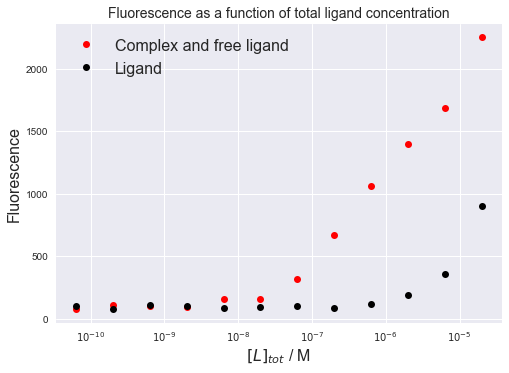

In [3]:
plt.semilogx(Ltot,F_PL_i, 'ro', label='Complex and free ligand')
plt.semilogx(Ltot,F_L_i, 'ko', label='Ligand')
plt.title('Fluorescence as a function of total ligand concentration', fontsize=14)
plt.xlabel('$[L]_{tot}$ / M', fontsize=16)
plt.ylabel('Fluorescence', fontsize=16)
plt.legend(fontsize=16)
plt.show()

The sampling examples will attempt to infer the value of the binding free energy, which is set above, using the data that is plotted above. 

Before moving on to the sampling part, defining a function that will help viewing the traces of the MCMC simulations.

In [4]:
def get_var_trace(mcmc_model, var_name):
    """
    Exract parameter trace from PyMC MCMC object.
    
    Parameters
    ----------
    mcmc_model: pymc.MCMC.MCMC
        PyMC MCMC object
    var_name: str
        The name of the parameter you wish to extract
    
    Returns
    -------
    If the variable has been found:
    trace: numpy.ndarray
        the trace of the parameter of interest.
    """
    found = False
    for stoch in mcmc_model.stochastics:
        if stoch.__name__ == 'DeltaG':
            found = True
            trace = stoch.trace._trace[0]
    if found:
        return trace
    else:
        print('Variable {0} not present in MCMC object'.format(var_name))
        

## Sampling with emcee

In [5]:
pymc_model = pymcmodels.make_model(Ptot, dPstated, Ltot, dLstated,
    top_complex_fluorescence=F_PL_i,
    top_ligand_fluorescence=F_L_i,
    use_primary_inner_filter_correction=True,
    use_secondary_inner_filter_correction=True,
    assay_volume=assay_volume, DG_prior='uniform')

mcmc_model, pymc_model = pymcmodels.run_mcmc_emcee(pymc_model, nwalkers=200, nburn=10, niter=500)

/Users/rossg/miniconda3/envs/py2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/pymcmodels.py:70: RuntimeWarning: invalid value encountered in divide
  scaling = (1 - np.exp(-alpha)) / alpha


 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec

/Users/rossg/miniconda3/envs/py2/lib/python2.7/site-packages/emcee-2.2.1-py2.7.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/rossg/miniconda3/envs/py2/lib/python2.7/site-packages/emcee-2.2.1-py2.7.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


### Viewing the trace of the Delta G

Defining a quick function to make it easy to view the traces:

Mean DeltaG = -10.642987 +/- 1.98148995691


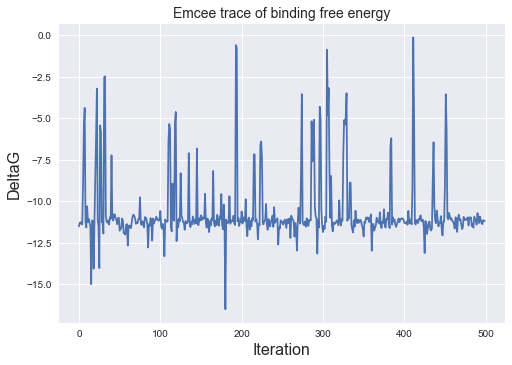

In [6]:
var_name = 'DeltaG'
trace_emcee = get_var_trace(mcmc_model, var_name)

print('Mean {0} = {1:2f} +/- {2}'.format(var_name, trace_emcee.mean(), trace_emcee.std()))
plt.plot(trace_emcee)
plt.title('Emcee trace of binding free energy', fontsize=14)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel(var_name, fontsize=16)
plt.show()

### Veiwing the sampling consistency

In [7]:
nrepeats = 9
var_name = 'DeltaG'
traces_emcee = []

for r in range(nrepeats):
    pymc_model = pymcmodels.make_model(Ptot, dPstated, Ltot, dLstated,
        top_complex_fluorescence=F_PL_i,
        top_ligand_fluorescence=F_L_i,
        use_primary_inner_filter_correction=True,
        use_secondary_inner_filter_correction=True,
        assay_volume=assay_volume, DG_prior='uniform')
    t0 = time()
    mcmc_model, pymc_model = pymcmodels.run_mcmc_emcee(pymc_model, nwalkers=200, nburn=100, niter=1000)
    print('\n Time for MCMC run {0} = {1:2f} seconds'.format(r, time() - t0))
    traces_emcee.append(get_var_trace(mcmc_model, var_name))

/Users/rossg/miniconda3/envs/py2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/bindingmodels.py:84: RuntimeWarning: invalid value encountered in log
  logL = np.log(Ltot)
/Users/rossg/miniconda3/envs/py2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/bindingmodels.py:88: RuntimeWarning: invalid value encountered in less
  sqrt_arg[sqrt_arg < 0.0] = 0.0 # ensure always positive
/Users/rossg/miniconda3/envs/py2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/bindingmodels.py:102: RuntimeWarning: invalid value encountered in less
  PL[PL < 0.0] = 0.0 # complex cannot have negative concentration
/Users/rossg/miniconda3/envs/py2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/pymcmodels.py:72: RuntimeWarning: invalid value encountered in less
  indices = np.where(np.abs(alpha) < 0.01)
/Users/rossg/miniconda3/envs/py2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/bindingmodels.py:83: RuntimeWarning

 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 0 = 59.037190 seconds
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 1 = 53.799713 seconds
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 2 = 54.988186 seconds
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 3 = 65.081131 seconds
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 4 = 58.544180 seconds
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 5 = 70.219427 seconds
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 6 = 57.075174 seconds
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 7 = 57.293987 seconds
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec
 Time for MCMC run 8 = 55.943118 seconds


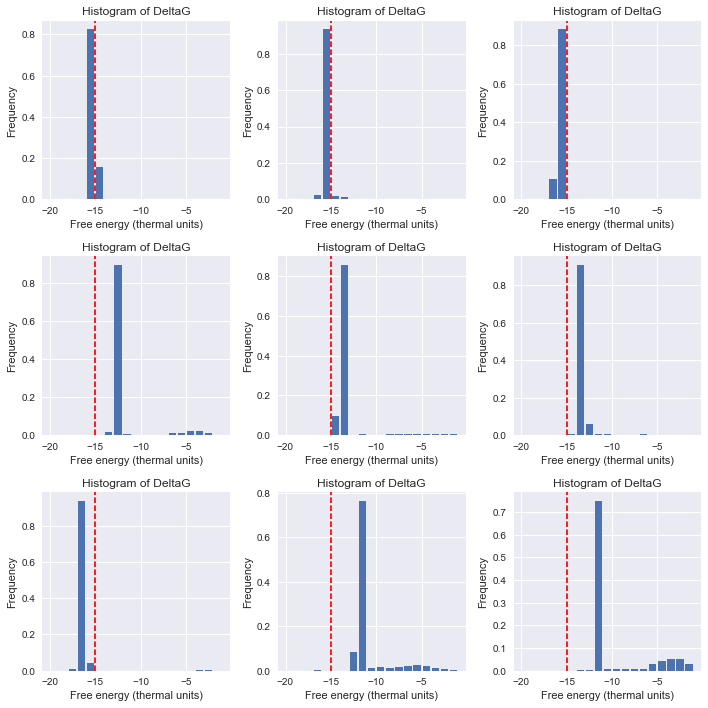

In [8]:
coords = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
bins = np.arange(-20, 0)

f, axarr = plt.subplots(3, 3, figsize=(10, 10))

for t, c in zip(traces_emcee, coords):
    hist, edges = np.histogram(t, bins=bins, normed=True)
    centers = edges[0:-1] + np.diff(edges) / 2.0
    axarr[c].bar(centers, hist)
    axarr[c].set_title('Histogram of {0}'.format(var_name))
    axarr[c].set_xlabel('Free energy (thermal units)')
    axarr[c].set_ylabel('Frequency')
    axarr[c].axvline(DeltaG, color='red', ls='--')
plt.tight_layout()
plt.show()

## Sampling with PyMC

### Viewing a single trace

In [9]:
pymc_model = pymcmodels.make_model(Ptot, dPstated, Ltot, dLstated,
    top_complex_fluorescence=F_PL_i,
    top_ligand_fluorescence=F_L_i,
    use_primary_inner_filter_correction=True,
    use_secondary_inner_filter_correction=True,
    assay_volume=assay_volume, DG_prior='uniform')

mcmc_model = pymcmodels.run_mcmc(pymc_model, nthin=20, nburn=100, niter=100000, map=True)

Mean DeltaG = -16.022155 +/- 0.0362034615929


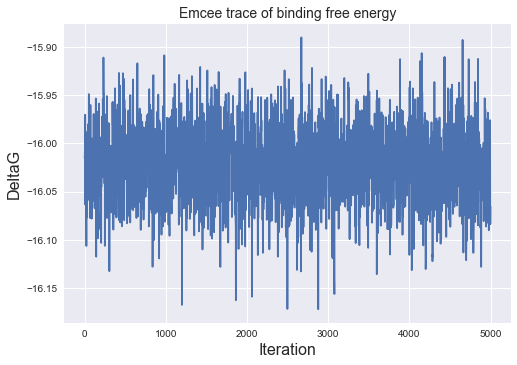

In [10]:
var_name = 'DeltaG'
trace_pymc = get_var_trace(mcmc_model, var_name)

print('Mean {0} = {1:2f} +/- {2}'.format(var_name, trace_pymc.mean(), trace_pymc.std()))
plt.plot(trace_pymc )
plt.title('Emcee trace of binding free energy', fontsize=14)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel(var_name, fontsize=16)
plt.show()

### Veiwing the sampling consistency

In [11]:
nrepeats = 9
var_name = 'DeltaG'
traces_pymc = []

for r in range(nrepeats):
    pymc_model = pymcmodels.make_model(Ptot, dPstated, Ltot, dLstated,
        top_complex_fluorescence=F_PL_i,
        top_ligand_fluorescence=F_L_i,
        use_primary_inner_filter_correction=True,
        use_secondary_inner_filter_correction=True,
        assay_volume=assay_volume, DG_prior='uniform')
    t0 = time()
    mcmc_model = pymcmodels.run_mcmc(pymc_model, nthin=20, nburn=100, niter=100000, map=True)
    print('Time for MCMC run {0} = {1:2f} seconds'.format(r, time() - t0))
    traces_pymc.append(get_var_trace(mcmc_model, var_name))

Time for MCMC run 0 = 102.224875 seconds
Time for MCMC run 1 = 101.651933 seconds
Time for MCMC run 2 = 99.374776 seconds
Time for MCMC run 3 = 104.353155 seconds
Time for MCMC run 4 = 96.334083 seconds
Time for MCMC run 5 = 103.196129 seconds
Time for MCMC run 6 = 98.731760 seconds
Time for MCMC run 7 = 109.117536 seconds
Time for MCMC run 8 = 102.003356 seconds


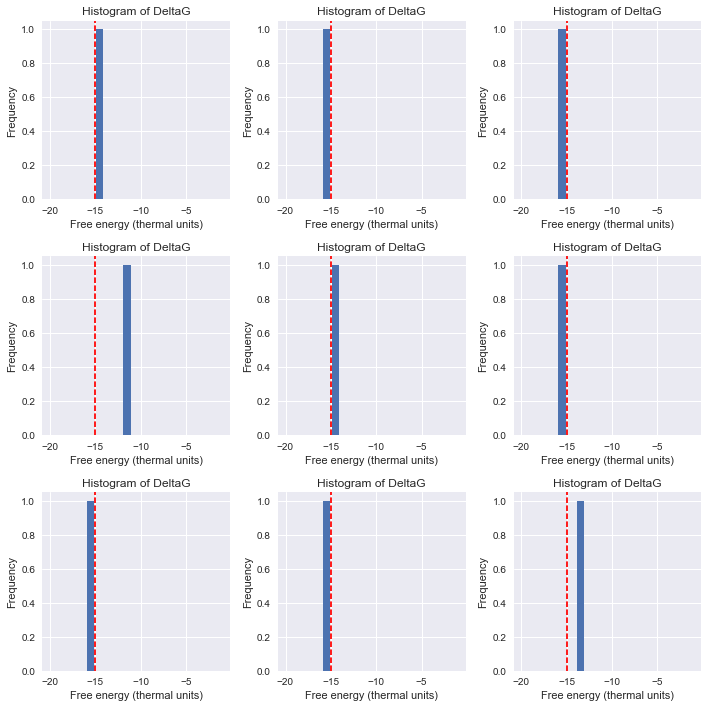

In [12]:
coords = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
bins = np.arange(-20, 0)

f, axarr = plt.subplots(3, 3, figsize=(10, 10))

for t, c in zip(traces_pymc, coords):
    hist, edges = np.histogram(t, bins=bins, normed=True)
    centers = edges[0:-1] + np.diff(edges) / 2.0
    axarr[c].bar(centers, hist)
    axarr[c].set_title('Histogram of {0}'.format(var_name))
    axarr[c].set_xlabel('Free energy (thermal units)')
    axarr[c].set_ylabel('Frequency')
    axarr[c].axvline(DeltaG, color='red', ls='--')
plt.tight_layout()
plt.show()